In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [33]:
df = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])

In [34]:
# Hiển thị thông tin tổng quan
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB
None
        date   meantemp   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [35]:
# Lấy chuỗi nhiệt độ
temperature = df['meantemp'].values
dates = df.index

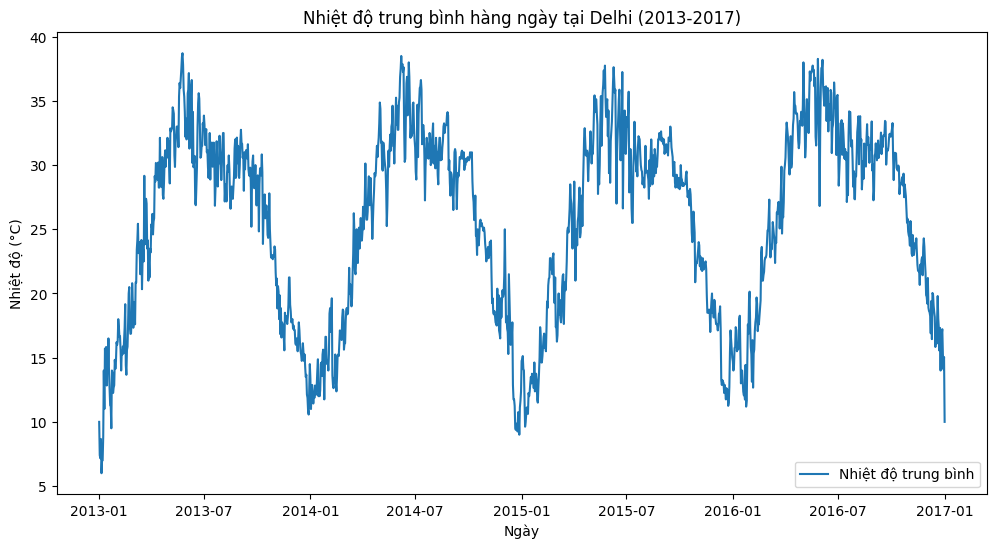

In [36]:
# Vẽ biểu đồ nhiệt độ trung bình theo thời gian
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['meantemp'], label='Nhiệt độ trung bình')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ (°C)')
plt.title('Nhiệt độ trung bình hàng ngày tại Delhi (2013-2017)')
plt.legend()
plt.show()

In [37]:
def gaussian(x, mu, sigma):
    return (1.0 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def gmm_em_1d(data, K=3, max_iter=30):
    n = len(data)
    np.random.seed(42)
    mu = np.random.choice(data, K)
    sigma = np.full(K, np.std(data))
    pi = np.full(K, 1/K)
    gamma = np.zeros((n, K))

    for _ in range(max_iter):
        # E-step
        for i in range(n):
            for k in range(K):
                gamma[i, k] = pi[k] * gaussian(data[i], mu[k], sigma[k])
            gamma[i, :] /= np.sum(gamma[i, :])

        # M-step
        N_k = np.sum(gamma, axis=0)
        for k in range(K):
            mu[k] = np.sum(gamma[:, k] * data) / N_k[k]
            sigma[k] = np.sqrt(np.sum(gamma[:, k] * (data - mu[k])**2) / N_k[k])
            pi[k] = N_k[k] / n

    labels = np.argmax(gamma, axis=1)
    return mu, sigma, pi, labels

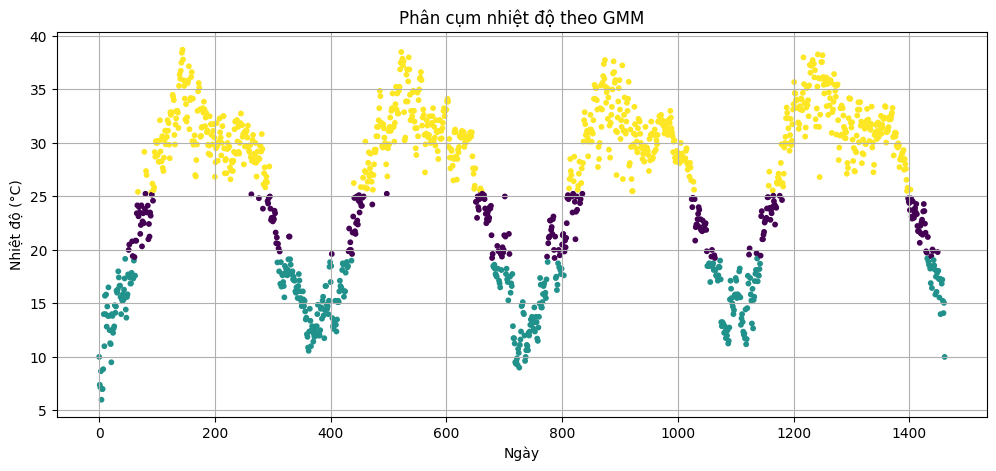

In [38]:
mu, sigma, pi, labels = gmm_em_1d(temperature)

# Vẽ biểu đồ phân cụm nhiệt độ
plt.figure(figsize=(12, 5))
plt.scatter(dates, temperature, c=labels, cmap='viridis', s=10)
plt.title("Phân cụm nhiệt độ theo GMM")
plt.xlabel("Ngày")
plt.ylabel("Nhiệt độ (°C)")
plt.grid(True)
plt.show()

In [39]:
# Dữ liệu gốc mỗi ngày
daily_series = df['meantemp']
daily_series.index = pd.to_datetime(daily_series.index)

# Trung bình trượt 3 ngày và 7 ngày
rolling_3d = daily_series.rolling(window=3, center=True).mean()
rolling_7d = daily_series.rolling(window=7, center=True).mean()

# Gộp lại
multi_res_df = pd.DataFrame({
    '1d': daily_series,
    '3d': rolling_3d,
    '7d': rolling_7d
})

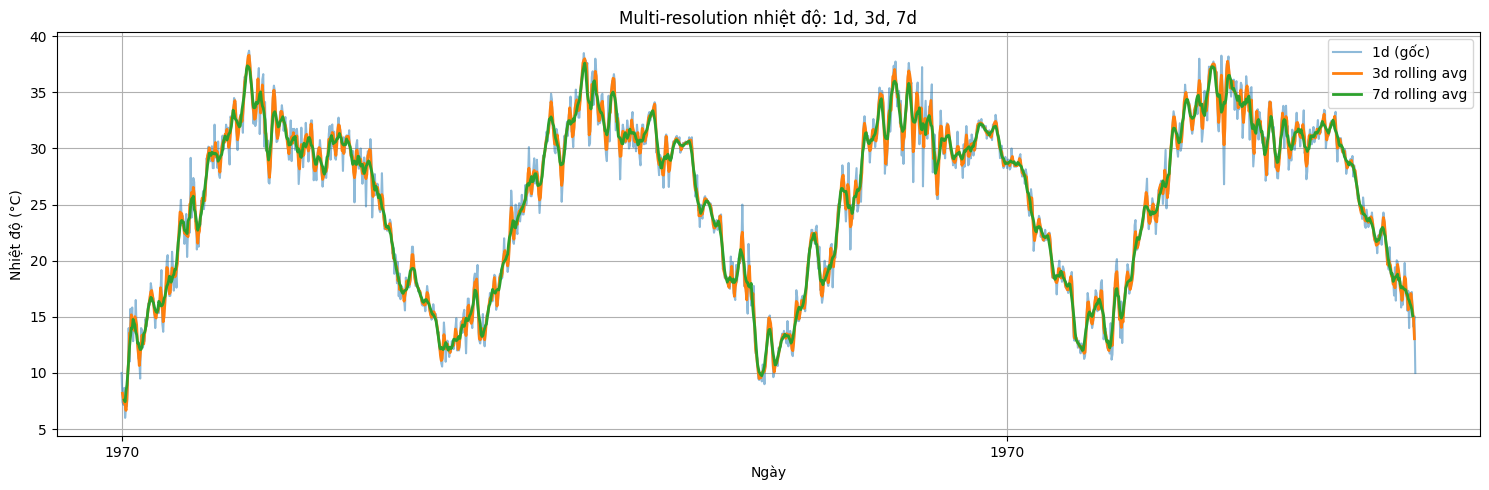

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(multi_res_df['1d'], label='1d (gốc)', alpha=0.5)
plt.plot(multi_res_df['3d'], label='3d rolling avg', linewidth=2)
plt.plot(multi_res_df['7d'], label='7d rolling avg', linewidth=2)
plt.title('Multi-resolution nhiệt độ: 1d, 3d, 7d')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
scaler = StandardScaler()
series_scaled = scaler.fit_transform(temperature.reshape(-1, 1)).flatten()

def create_sequences(data, input_len=30, forecast_len=7):
    X, Y = [], []
    for i in range(len(data) - input_len - forecast_len):
        X.append(data[i:i + input_len])
        Y.append(data[i + input_len:i + input_len + forecast_len])
    return np.array(X), np.array(Y)

X, Y = create_sequences(series_scaled, 30, 7)
split = int(len(X) * 0.8)
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

In [42]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_len=30, output_len=7, d_model=30, nhead=3, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.positional_encoding = self._positional_encoding(input_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_len)

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.embedding(x) + self.positional_encoding.to(x.device)
        x = self.encoder(x)
        return self.decoder(x[:, -1, :])  # (batch, output_len)

    def _positional_encoding(self, length, d_model):
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # (1, length, d_model)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, Y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1, Loss: 1.3379
Epoch 2, Loss: 0.7741
Epoch 3, Loss: 0.3497
Epoch 4, Loss: 0.2660
Epoch 5, Loss: 0.2616
Epoch 6, Loss: 0.2292
Epoch 7, Loss: 0.2037
Epoch 8, Loss: 0.1953
Epoch 9, Loss: 0.1964
Epoch 10, Loss: 0.2001
Epoch 11, Loss: 0.1966
Epoch 12, Loss: 0.1868
Epoch 13, Loss: 0.1757
Epoch 14, Loss: 0.1686
Epoch 15, Loss: 0.1685
Epoch 16, Loss: 0.1634
Epoch 17, Loss: 0.1632
Epoch 18, Loss: 0.1616
Epoch 19, Loss: 0.1592
Epoch 20, Loss: 0.1572


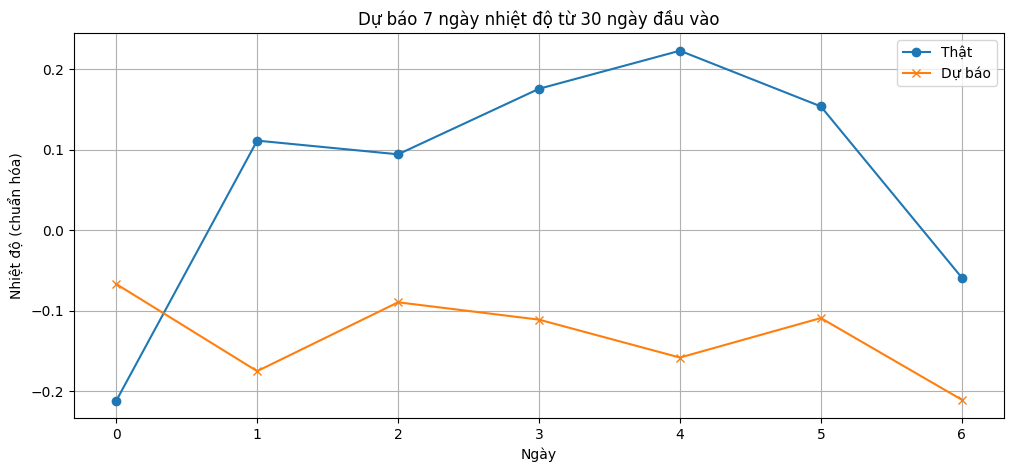

In [44]:
# 5. Dự báo và hiển thị
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
preds = model(X_test_tensor).detach().cpu().numpy()
Y_true = Y_test

plt.figure(figsize=(12,5))
plt.plot(Y_true[0], label='Thật', marker='o')
plt.plot(preds[0], label='Dự báo', marker='x')
plt.title('Dự báo 7 ngày nhiệt độ từ 30 ngày đầu vào')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ (chuẩn hóa)')
plt.grid(True)
plt.legend()
plt.show()